In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vurvikkorukonda","key":"8b4b93ba6b8e4ac71d53374cb5e4d7c5"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d shubham2703/five-crop-diseases-dataset -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/shubham2703/five-crop-diseases-dataset
License(s): CC-BY-NC-SA-4.0


In [7]:
import os

dataset_path = "/content/data"
print("Dataset files:", os.listdir(dataset_path))


Dataset files: ['Crop Diseases Dataset']


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (3456, 5184, 3)


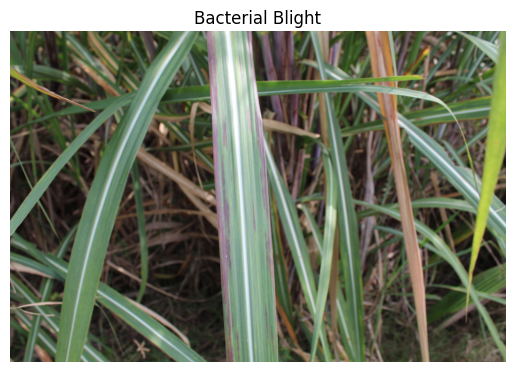

In [9]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Bacterial Blight")

Image shape: (3024, 4032, 3)


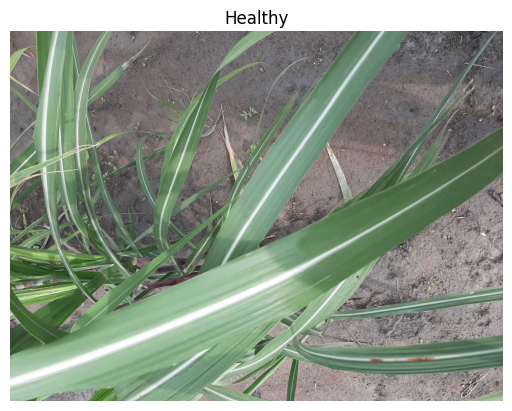

In [10]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Healthy")

Image shape: (3456, 5184, 3)


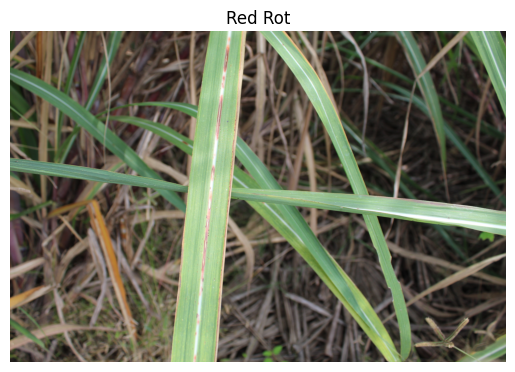

In [11]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Red Rot")

In [38]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane'

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [40]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 30

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 300 files belonging to 3 classes.


In [41]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [42]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # ⬅️ Change 3 if you have a different number of classes

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [44]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.3463 - loss: 5.3692 - val_accuracy: 0.1250 - val_loss: 2.8268
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.3867 - loss: 4.3316 - val_accuracy: 0.2500 - val_loss: 2.9058
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.3650 - loss: 4.1078 - val_accuracy: 0.5625 - val_loss: 1.5942
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.4716 - loss: 3.5518 - val_accuracy: 0.6875 - val_loss: 1.4207
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.4685 - loss: 3.0704 - val_accuracy: 0.5625 - val_loss: 1.8517
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4370 - loss: 2.9477 - val_accuracy: 0.5625 - val_loss: 1.8452
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.4806 - loss: 2.8944 - val_accuracy: 0.5625 - val_loss: 2.1726
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.4480 - loss: 2.7575 - val_accuracy: 0.6875 - val_loss:

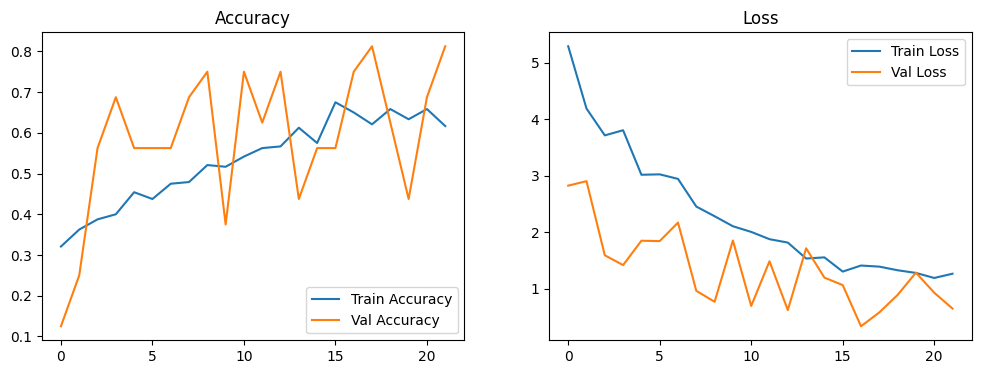

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [49]:
model_vgg.save("crop_disease_sugarcane_model_vgg16.keras")


In [48]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()

    return predicted_class, confidence

# Example:
img_path = "/content/S_BLB (1).JPG"  # ⬅️ Replace with a real test image
pred_class, conf = predict_image(img_path, model_vgg)
print(f"Predicted Class: {pred_class} | Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: 0 | Confidence: 0.36


potato classification


Image shape: (256, 256, 3)


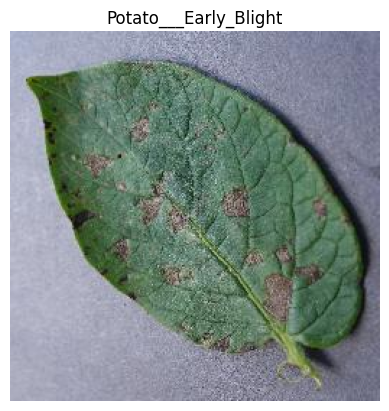

In [25]:
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Potato/",
                        target_class="Potato___Early_Blight")

Image shape: (256, 256, 3)


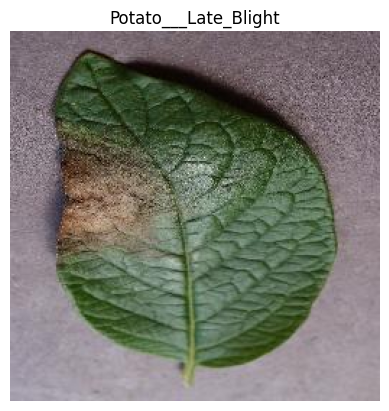

In [26]:
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Potato/",
                        target_class="Potato___Late_Blight")

Image shape: (256, 256, 3)


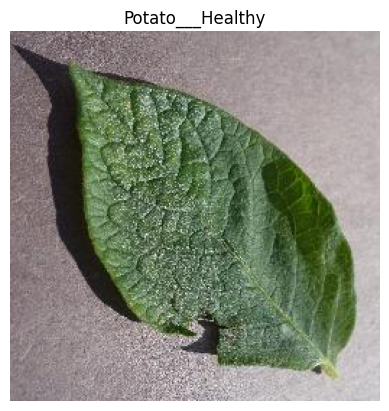

In [27]:
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Potato/",
                        target_class="Potato___Healthy")

In [28]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Potato'

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [30]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 30


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [31]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # ⬅️ Change 3 if you have a different number of classes

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [34]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.5524 - loss: 3.0379 - val_accuracy: 0.8221 - val_loss: 0.5365
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.7204 - loss: 1.1765 - val_accuracy: 0.8990 - val_loss: 0.2650
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.7960 - loss: 0.7346 - val_accuracy: 0.9135 - val_loss: 0.1927
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.8488 - loss: 0.4951 - val_accuracy: 0.9231 - val_loss: 0.1935
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.8680 - loss: 0.4012 - val_accuracy: 0.9519 - val_loss: 0.1440
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8961 - loss: 0.2849 - val_accuracy: 0.9375 - val_loss: 0.1669
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8954 - loss: 0.2702 - val_accuracy: 0.9375 - val_loss: 0.1582
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.9039 - loss: 0

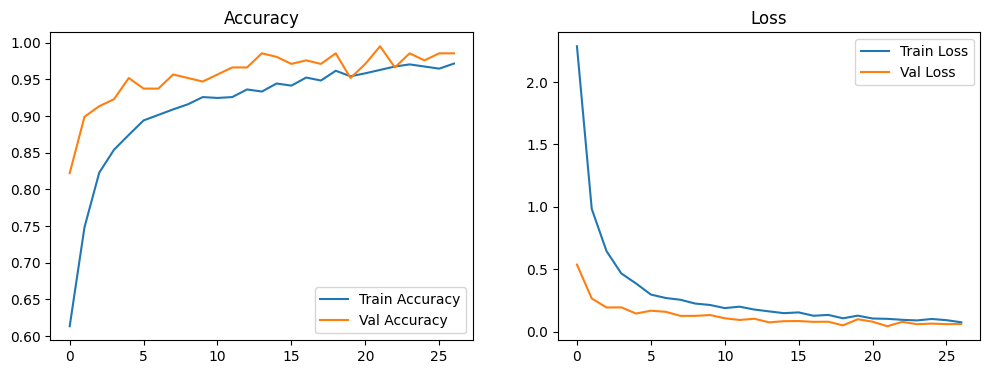

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [36]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()

    return predicted_class, confidence

# Example:
img_path = "/content/0c2628d4-8d64-48a9-a157-19a9c902e304___RS_LB 4590.JPG"  # ⬅️ Replace with a real test image
pred_class, conf = predict_image(img_path, model_vgg)
print(f"Predicted Class: {pred_class} | Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Predicted Class: 2 | Confidence: 0.86


In [37]:
model_vgg.save("crop_disease_potato_model_vgg16.keras")


corn classification


In [50]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Corn'

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [52]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 30

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 3852 files belonging to 4 classes.


In [53]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [54]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation='softmax')(x)  # ⬅️ Change 4 if you have a different number of classes

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [56]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.4333 - loss: 3.9490 - val_accuracy: 0.8333 - val_loss: 0.4413
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.7408 - loss: 0.9708 - val_accuracy: 0.9141 - val_loss: 0.2582
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.8223 - loss: 0.5257 - val_accuracy: 0.9167 - val_loss: 0.2316
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.8478 - loss: 0.4167 - val_accuracy: 0.9297 - val_loss: 0.1540
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.8533 - loss: 0.3764 - val_accuracy: 0.9375 - val_loss: 0.1789
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.8936 - loss: 0.2895 - val_accuracy: 0.9401 - val_loss: 0.1668
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.8972 - loss: 0.2612 - val_accuracy: 0.9427 - val_loss: 0.1611
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9032 - loss: 0

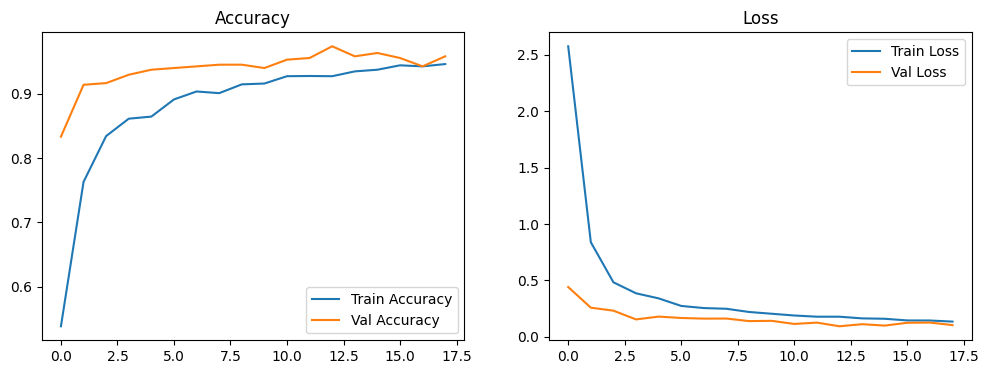

In [57]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [60]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()

    return predicted_class, confidence

# Example:
img_path = "/content/image (3).JPG"  # ⬅️ Replace with a real test image
pred_class, conf = predict_image(img_path, model_vgg)
print(f"Predicted Class: {pred_class} | Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: 0 | Confidence: 0.31


In [61]:
model_vgg.save("crop_disease_corn_model_vgg16.keras")